Packages used: 



In [229]:
library(dplyr)
library(ggplot2)
library(readr)
library(rpart)
library(caret)
library(rpart.plot)
library(caTools)
library(party)
library(Amelia)
library(tidyr)
library(randomForest)
library(e1071)
library(ROSE)


**Loading the dataset**



In [252]:
HR_data <- read.csv("C:/Users/morde/Desktop/CDS/data/HR_data.csv", na.strings=c(""), stringsAsFactors = FALSE)



Brief peek into the dataset



In [253]:
head(HR_data)



enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NA,NA,1,36,1
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
11561,city_21,0.624,NA,No relevent experience,Full time course,Graduate,STEM,5,NA,NA,never,83,0
33241,city_115,0.789,NA,No relevent experience,NA,Graduate,Business Degree,<1,NA,Pvt Ltd,never,52,1
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0
21651,city_176,0.764,NA,Has relevent experience,Part time course,Graduate,STEM,11,NA,NA,1,24,1


In [254]:
glimpse(HR_data)



Observations: 19,158
Variables: 14
$ enrollee_id            <int> 8949, 29725, 11561, 33241, 666, 21651, 28806...
$ city                   <chr> "city_103", "city_40", "city_21", "city_115"...
$ city_development_index <dbl> 0.920, 0.776, 0.624, 0.789, 0.767, 0.764, 0....
$ gender                 <chr> "Male", "Male", NA, NA, "Male", NA, "Male", ...
$ relevent_experience    <chr> "Has relevent experience", "No relevent expe...
$ enrolled_university    <chr> "no_enrollment", "no_enrollment", "Full time...
$ education_level        <chr> "Graduate", "Graduate", "Graduate", "Graduat...
$ major_discipline       <chr> "STEM", "STEM", "STEM", "Business Degree", "...
$ experience             <chr> ">20", "15", "5", "<1", ">20", "11", "5", "1...
$ company_size           <chr> NA, "50-99", NA, NA, "50-99", NA, "50-99", "...
$ company_type           <chr> NA, "Pvt Ltd", NA, "Pvt Ltd", "Funded Startu...
$ last_new_job           <chr> "1", ">4", "never", "never", "4", "1", "1", ...
$ training_hours 

**Data Pre-Processing**



In [255]:
colnames(HR_data)



[1] "enrollee_id"            "city"                   "city_development_index"
 [4] "gender"                 "relevent_experience"    "enrolled_university"   
 [7] "education_level"        "major_discipline"       "experience"            
[10] "company_size"           "company_type"           "last_new_job"          
[13] "training_hours"         "target"

*Dropping unneeded columns*

Columns **enrollee_id** and **city** are dropped since they are inconsequential to our analysis and prediction


In [256]:
HR_data <- HR_data[,-c(1,2)]



In [257]:
colnames(HR_data)



[1] "city_development_index" "gender"                 "relevent_experience"   
 [4] "enrolled_university"    "education_level"        "major_discipline"      
 [7] "experience"             "company_size"           "company_type"          
[10] "last_new_job"           "training_hours"         "target"

**Missing values**



In [258]:
colSums(is.na(HR_data))



city_development_index                 gender    relevent_experience 
                     0                   4508                      0 
   enrolled_university        education_level       major_discipline 
                   386                    460                   2813 
            experience           company_size           company_type 
                    65                   5938                   6140 
          last_new_job         training_hours                 target 
                   423                      0                      0

Missing values present in **8** out of **12** columns


Visualization of the missing data concentration in each column


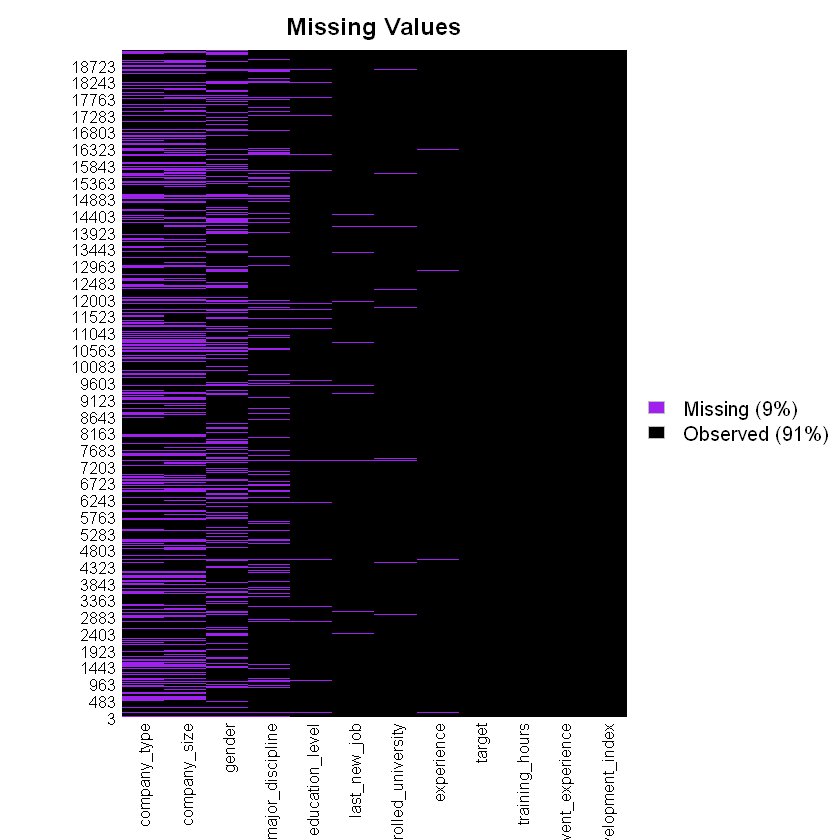

In [259]:
missmap(HR_data, main = 'Missing Values', col = c('purple', 'black'))



Looking at the percentage of the missing values in their respective groups



In [260]:
round(colMeans(is.na(HR_data)) * 100,3)



city_development_index                 gender    relevent_experience 
                 0.000                 23.531                  0.000 
   enrolled_university        education_level       major_discipline 
                 2.015                  2.401                 14.683 
            experience           company_size           company_type 
                 0.339                 30.995                 32.049 
          last_new_job         training_hours                 target 
                 2.208                  0.000                  0.000

The column with the largest number of missing data is **company_type(32.049%)**, while the column with the smallest is **experience(0.339%)**



For the groups with few missing values, we shall drop the rows with the missing data, since the data loss is close to insignificant.
The columns are **education_level, experience, last_new_job and enrolled_university**


In [261]:
HR_data <- HR_data %>% 
  filter(complete.cases(education_level,experience,last_new_job,enrolled_university))


In [262]:
round(colMeans(is.na(HR_data)) * 100,3)



city_development_index                 gender    relevent_experience 
                 0.000                 21.444                  0.000 
   enrolled_university        education_level       major_discipline 
                 0.000                  0.000                 12.335 
            experience           company_size           company_type 
                 0.000                 29.477                 30.399 
          last_new_job         training_hours                 target 
                 0.000                  0.000                  0.000

*Dealing with gender missing data*



In [263]:
unique(HR_data$gender)



[1] "Male"   NA       "Female" "Other"

The count for each gender:



In [264]:
HR_data %>% 
  group_by(gender) %>% 
  summarise(count=n())


gender,count
NA,3863
Female,1206
Male,12772
Other,173


The male gender is densely populated in the group, while the females are much less.


Classifying the gender "Other" as male for typical purposes


In [265]:
other <- which(HR_data$gender == "Other")

for (i in other) {
  HR_data$gender[i] <- "Male"
}    

unique(HR_data$gender)


[1] "Male"   NA       "Female"

Losing the N/A rows on gender and observing the percentage loss of our dataset



In [266]:
complete <- HR_data %>% 
  filter(complete.cases(gender))

 100 - (nrow(complete)/nrow(HR_data) * 100)


[1] 21.44443

In [267]:
HR_data <- complete
sum(is.na(HR_data$gender))


[1] 0

*Dealing with major_discipline missing values*


Observing the count of each discipline 


In [268]:
unique(HR_data$major_discipline)

HR_data %>% 
  group_by(major_discipline) %>% 
  summarise(count=n())


[1] "STEM"            NA                "Arts"            "Humanities"     
[5] "Business Degree" "No Major"        "Other"

major_discipline,count
NA,1674
Arts,201
Business Degree,252
Humanities,547
No Major,176
Other,284
STEM,11017


Replacing the fewer N/A values with the overly populated STEM discipline. In this case, an assumption is made that a majority of the N/A values are in the STEM category



In [269]:
HR_data$major_discipline = replace_na(HR_data$major_discipline,'STEM')



In [270]:
sum(is.na(HR_data$major_discipline))



[1] 0

*Dealing with company size missing values*



In [351]:
unique(HR_data$company_size)



[1] 1000-4999 50-99     100-500   <NA>      Unknown   10000+    5000-9999
[8] 500-999   <10      
Levels: <10 100-500 1000-4999 10000+ 50-99 500-999 5000-9999 Unknown

In [352]:
size_na <- which(!complete.cases(HR_data$company_size))

for (i in size_na){
    HR_data$company_size[i] <- "Unknown"
}


In [353]:
sum(is.na(HR_data$company_size))



[1] 0

*Dealing with company type missing values*



In [354]:
unique(HR_data$company_type)



[1] Pvt Ltd             Other               Funded Startup     
[4] Public Sector       NGO                 Early Stage Startup
6 Levels: Early Stage Startup Funded Startup NGO Other ... Pvt Ltd

An other column exists, so we input the missing values to it



In [355]:
HR_data$company_type = replace_na(HR_data$company_type,'Other')



In [356]:
sum(is.na(HR_data$company_type))



[1] 0

Looking at the final result:



In [357]:
colSums(is.na(HR_data))



city_development_index                 gender    relevant_experience 
                     0                      0                      0 
   enrolled_university        education_level       major_discipline 
                     0                      0                      0 
            experience           company_size           company_type 
                     0                      0                      0 
          last_new_job         training_hours                 target 
                     0                      0                      0

No missing values are present in the dataset






**Data types**


In [358]:
glimpse(HR_data)



Observations: 14,151
Variables: 12
$ city_development_index <dbl> 0.624, 0.550, 0.893, 0.624, 0.897, 0.895, 0....
$ gender                 <fct> Male, Male, Male, Male, Male, Male, Male, Ma...
$ relevant_experience    <fct> Has relevent experience, Has relevent experi...
$ enrolled_university    <fct> no enrollment, no enrollment, no enrollment,...
$ education_level        <fct> Masters, Graduate, Graduate, Graduate, Maste...
$ major_discipline       <fct> STEM, STEM, STEM, STEM, STEM, STEM, STEM, ST...
$ experience             <fct> >20, 5, 6, 17, 8, 9, 4, 10, >20, 9, 5, >20, ...
$ company_size           <fct> 1000-4999, 50-99, 100-500, 100-500, 100-500,...
$ company_type           <fct> Pvt Ltd, Pvt Ltd, Pvt Ltd, Pvt Ltd, Pvt Ltd,...
$ last_new_job           <fct> 2, 1, never, 3, 4, 1, 2, 2, 2, 4, 1, 1, 1, 1...
$ training_hours         <int> 56, 74, 88, 42, 33, 89, 92, 43, 51, 31, 31, ...
$ target                 <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...


Changing all the character columns in the dataset to factor since they are categories with levels:



In [359]:
# gender
unique(HR_data$gender)
HR_data$gender <- factor(HR_data$gender)

# relevant experience
unique(HR_data$relevent_experience)
HR_data$relevent_experience <- factor(HR_data$relevent_experience)

# enrolled university
unique(HR_data$enrolled_university)
HR_data$enrolled_university <- factor(HR_data$enrolled_university, levels = c("Full time course", "Part time course", "no_enrollment"))

# education level
unique(HR_data$education_level)
HR_data$education_level <- factor(HR_data$education_level, levels = c("Primary School", "High School", "Graduate", "Masters", "Phd"))

# major discipline
unique(HR_data$major_discipline)
HR_data$major_discipline <- factor(HR_data$major_discipline)

# experience
unique(HR_data$experience)
HR_data$experience <- factor(HR_data$experience)

# company size
unique(HR_data$company_size)
HR_data$company_size<- factor(HR_data$company_size, levels = c("<10","10-49","50-99","100-500","500-999","1000-4999","5000-9999","10000+","Unknown"))

# company type
unique(HR_data$company_type)
HR_data$company_type<- factor(HR_data$company_type)

# last new job
unique(HR_data$last_new_job)
HR_data$last_new_job<- factor(HR_data$last_new_job, levels = c("never", "1", "2", "3", "4", ">4"))

# target
unique(HR_data$target)
HR_data$target<- factor(HR_data$target)


[1] Male   Female
Levels: Female Male

NULL

ERROR: Error in `$<-.data.frame`(`*tmp*`, relevent_experience, value = structure(integer(0), .Label = character(0), class = "factor")): replacement has 0 rows, data has 14151


Another look at the result:



In [360]:
glimpse(HR_data)



Observations: 14,151
Variables: 12
$ city_development_index <dbl> 0.624, 0.550, 0.893, 0.624, 0.897, 0.895, 0....
$ gender                 <fct> Male, Male, Male, Male, Male, Male, Male, Ma...
$ relevant_experience    <fct> Has relevent experience, Has relevent experi...
$ enrolled_university    <fct> no enrollment, no enrollment, no enrollment,...
$ education_level        <fct> Masters, Graduate, Graduate, Graduate, Maste...
$ major_discipline       <fct> STEM, STEM, STEM, STEM, STEM, STEM, STEM, ST...
$ experience             <fct> >20, 5, 6, 17, 8, 9, 4, 10, >20, 9, 5, >20, ...
$ company_size           <fct> 1000-4999, 50-99, 100-500, 100-500, 100-500,...
$ company_type           <fct> Pvt Ltd, Pvt Ltd, Pvt Ltd, Pvt Ltd, Pvt Ltd,...
$ last_new_job           <fct> 2, 1, never, 3, 4, 1, 2, 2, 2, 4, 1, 1, 1, 1...
$ training_hours         <int> 56, 74, 88, 42, 33, 89, 92, 43, 51, 31, 31, ...
$ target                 <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...


**Other pre-processing**



*relevant experience*

Renaming the column name to remove a spell error


In [361]:
HR_data <- HR_data %>% 
        rename(
          relevant_experience = "relevent_experience"
        )


ERROR: Unknown column `relevent_experience` 

*enrolled university*



In [362]:
HR_data$enrolled_university <- as.character(HR_data$enrolled_university)

enrolled <- which(HR_data$enrolled_university == "no_enrollment")

for (i in enrolled) {
  HR_data$enrolled_university[i] <- "no enrollment"
}

HR_data$enrolled_university <- as.factor(HR_data$enrolled_university)


*company type*



In [363]:
# dealing with company type missing values
unique(HR_data$company_type)

HR_data$company_type = replace_na(HR_data$company_type,'Other')

sum(is.na(HR_data$company_type))

colSums(is.na(HR_data))


[1] Pvt Ltd             Other               Funded Startup     
[4] Public Sector       NGO                 Early Stage Startup
6 Levels: Early Stage Startup Funded Startup NGO Other ... Pvt Ltd

[1] 0

city_development_index                 gender    relevant_experience 
                     0                      0                      0 
   enrolled_university        education_level       major_discipline 
                     0                      0                      0 
            experience           company_size           company_type 
                     0                      0                      0 
          last_new_job         training_hours                 target 
                     0                      0                      0

**Dependent variable analysis**

Changing the 1 and 0 factors to their clear meanings:


In [364]:
HR_data$target <- ifelse(HR_data$target == 1, "Job change", "No job change")



In [365]:
count_targ <- HR_data %>% 
  group_by(target) %>% 
     summarise(count=n())

count_targ


target,count
Job change,3259
No job change,10892


Percentage of each:



In [366]:
# looking for a job change
(3259/(3259+10892)) * 100

# not looking for a job change
(10892/(3259+10892)) * 100


[1] 23.03017

[1] 76.96983

Visualization of the target count variable:



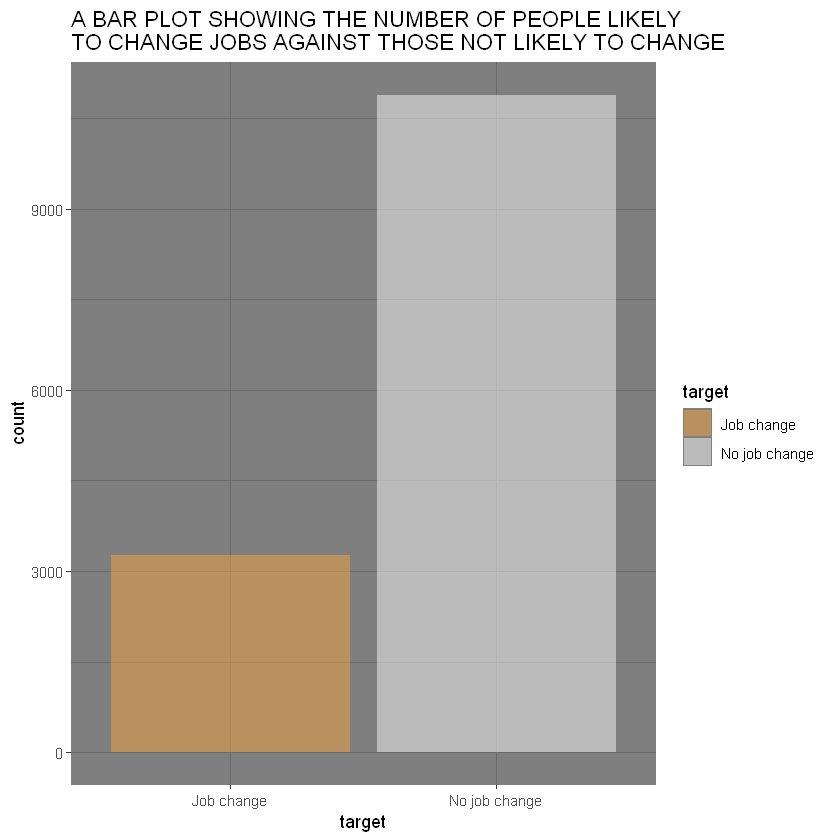

In [367]:
ggplot(count_targ, aes(x=target, y=count, fill=target))+
  geom_col(alpha=0.5)+
    scale_fill_brewer(palette = "PuOr")+
    labs(title = "A BAR PLOT SHOWING THE NUMBER OF PEOPLE LIKELY \nTO CHANGE JOBS AGAINST THOSE NOT LIKELY TO CHANGE")+
  theme_dark()


**Independent variable analysis**



**City development index**



Descriptive statistics(Maximum, Minimum, Median):


In [368]:
HR_data %>% 
   summarise(max=max(city_development_index), min=min(city_development_index), median=median(city_development_index))


max,min,median
0.949,0.448,0.91


A high median(0.91) indicates that most cities that the employees work in are highly developed, as per their index


A visual showing the distribution of this variable:


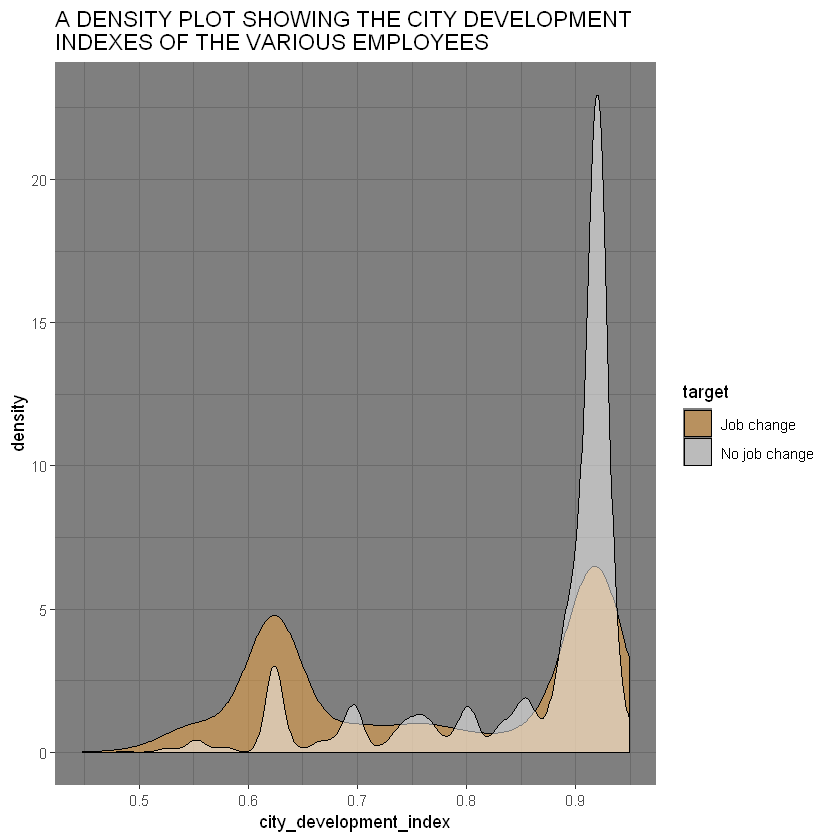

In [369]:
ggplot(HR_data, aes(x=city_development_index, fill=target))+
           geom_density(alpha=0.5)+
           scale_fill_brewer(palette = "PuOr")+
           labs(title = "A DENSITY PLOT SHOWING THE CITY DEVELOPMENT \nINDEXES OF THE VARIOUS EMPLOYEES")+
           theme_dark()


As seen above, majority of the people working for companies in lower developed cities seek a change in jobs, while those at more developed cities are content with their current job positions

A boxplot summarises this further:


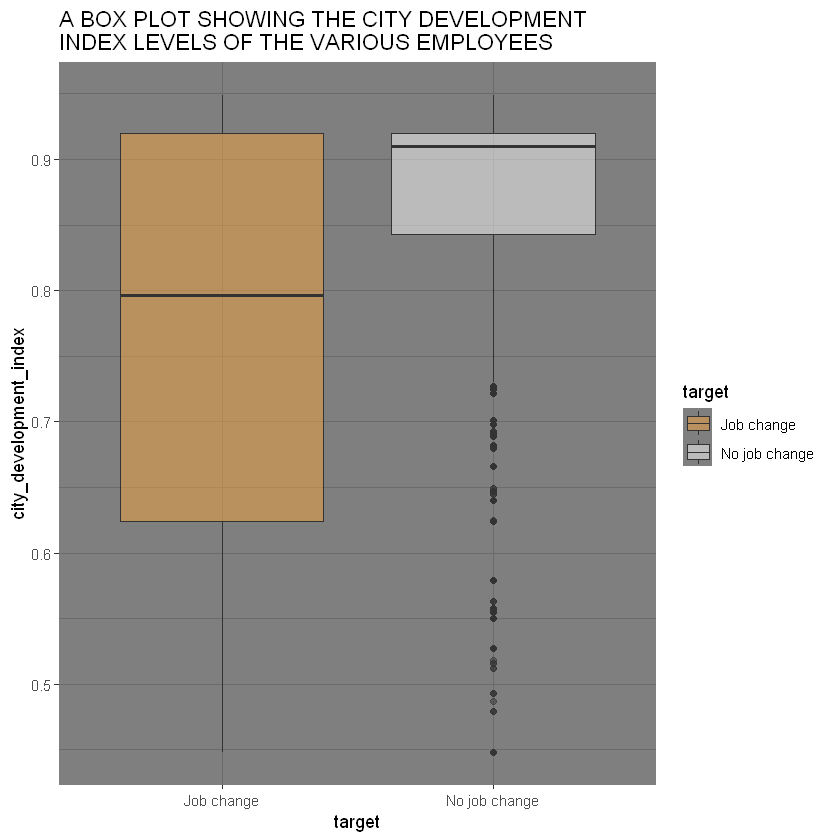

In [370]:
ggplot(HR_data, aes(x=target, y=city_development_index, fill=target))+
           geom_boxplot(alpha=0.5)+
           scale_fill_brewer(palette = "PuOr")+
           labs(title = "A BOX PLOT SHOWING THE CITY DEVELOPMENT \nINDEX LEVELS OF THE VARIOUS EMPLOYEES")+
           theme_dark()
           


**Gender**


Count of each: 


In [371]:
HR_data %>% 
  group_by(gender) %>% 
   summarise(count=n())


gender,count
Female,1206
Male,12945


Count of those likely to change jobs:



In [372]:
 HR_data %>%
  filter(target=="Job change") %>% 
  group_by(gender) %>%
  summarise(count=n())


gender,count
Female,313
Male,2946


Job change percentage of each gender:



In [373]:
# females looking for a job change
 (313/1206) * 100

# males looking for a job change
 (2946/12945) * 100


[1] 25.95357

[1] 22.75782

Females(at 25.95%) are more inclined to change jobs than males(at 22.75%)



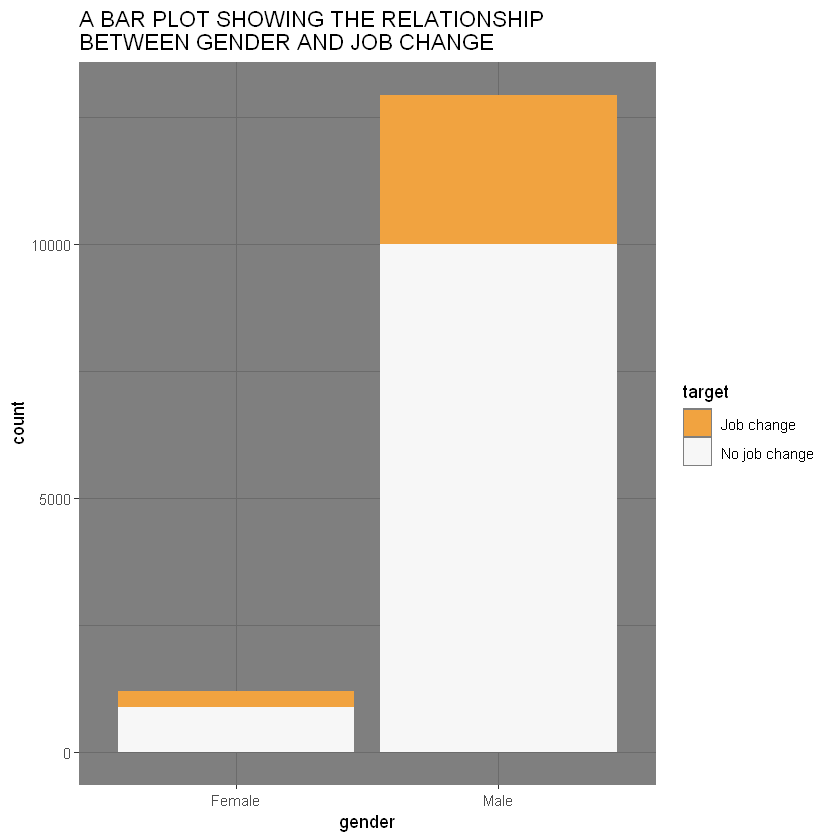

In [374]:
 ggplot(HR_data, aes(x=gender, fill=target))+
   geom_bar(position = "stack")+
     scale_fill_brewer(palette = "PuOr")+
    labs(title="A BAR PLOT SHOWING THE RELATIONSHIP \nBETWEEN GENDER AND JOB CHANGE")+
     theme_dark()


**Relevant experience**


The number of people in the each experience level:
 
 


In [375]:
 HR_data %>% 
   group_by(relevant_experience) %>% 
   summarise(count=n())


relevant_experience,count
Has relevent experience,10664
No relevent experience,3487


Most people have relevant experience in the field required, as shown above



Looking at the relevant experience of the group seeking a job change:


In [376]:
 HR_data %>% 
   filter(target=="Job change") %>% 
   group_by(relevant_experience) %>%
   summarise(count=n())


relevant_experience,count
Has relevent experience,2110
No relevent experience,1149


The ratios of those looking for a job change as per their relevant experience:



In [377]:
 # those with relevant experience looking for a job change
 (2210/10664) * 100

 # those with no relevant experience looking for a job change
 (1149/3487) * 100


[1] 20.72393

[1] 32.95096

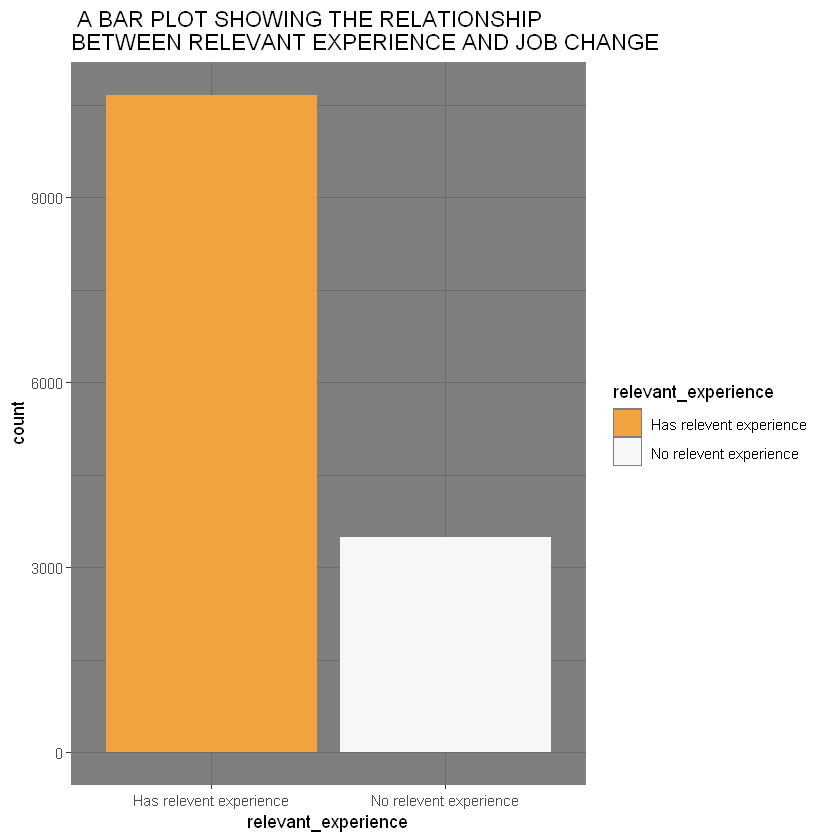

In [378]:
 ggplot(HR_data, aes(x=relevant_experience, fill=relevant_experience))+
   geom_bar()+
            scale_fill_brewer(palette = "PuOr")+
            labs(title=" A BAR PLOT SHOWING THE RELATIONSHIP \nBETWEEN RELEVANT EXPERIENCE AND JOB CHANGE")+
            theme_dark()


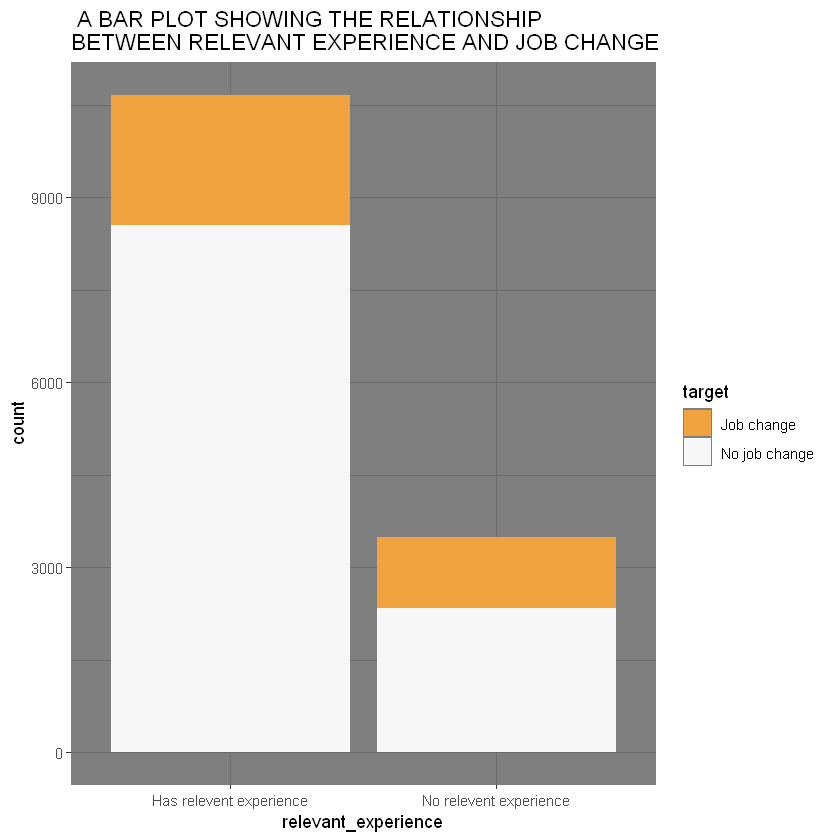

In [379]:
 ggplot(HR_data, aes(x=relevant_experience, fill=target))+
            geom_bar(position = "stack")+
            scale_fill_brewer(palette = "PuOr")+
            labs(title=" A BAR PLOT SHOWING THE RELATIONSHIP \nBETWEEN RELEVANT EXPERIENCE AND JOB CHANGE")+
            theme_dark()


 

Those with no relevant experience(32.95%) are more likely to change jobs, than those with relevant experience(20.72%)

 
 **Enrolled University**
 
 The number of people in each university course category, or in no university:
 


In [380]:
 HR_data %>% 
   group_by(enrolled_university) %>% 
   summarise(count=n())


enrolled_university,count
Full time course,2516
no enrollment,10773
Part time course,862


The number of people likely to change jobs, in relation to their university enrollment status:
 


In [381]:
 HR_data %>% 
   filter(target=="Job change") %>% 
   group_by(enrolled_university) %>%
   summarise(count=n())


enrolled_university,count
Full time course,928
no enrollment,2142
Part time course,189


The ratios:



In [382]:
 # full time course looking for a job change
 (928/2516) * 100
 
 # part time course looking for a job change
 (189/862) * 100
 
 #  no enrollment looking for a job change
 (2142/10773) * 100


[1] 36.88394

[1] 21.92575

[1] 19.88304

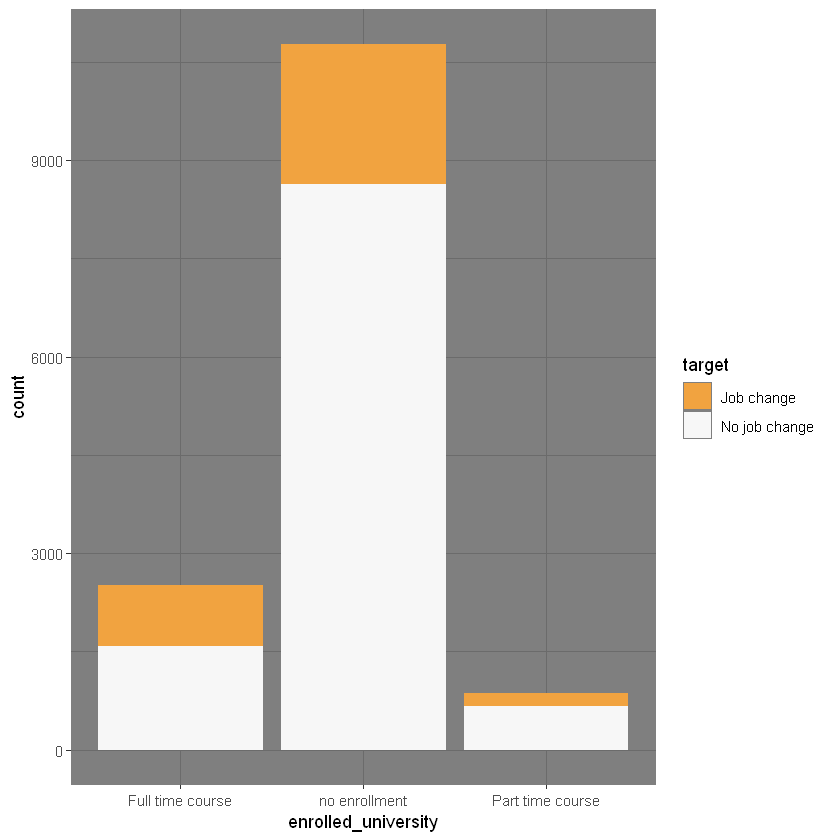

In [383]:
 ggplot(HR_data, aes(x=enrolled_university, fill=target))+
            geom_bar(position = "stack")+
            scale_fill_brewer(palette = "PuOr")+
            theme_dark()


Those enrolled full time are the likeliest to change jobs, whereas those not enrolled in any university are the least likely to change jobs
 
 
 **Education Level**
 
 
 The count of each level of education:
 
 


In [384]:
 HR_data %>% 
   group_by(education_level) %>% 
   summarise(count=n())


education_level,count
Primary School,206
High School,1459
Graduate,8889
Masters,3272
Phd,325


Most of the people are university graduates, as per the data above
 
 
The number of each education level for the ones looking for a job change

 


In [385]:
 HR_data %>% 
   filter(target=="Job change") %>% 
   group_by(education_level) %>%
   summarise(count=n())


education_level,count
Primary School,21
High School,271
Graduate,2297
Masters,627
Phd,43


 

Looking at the ratios and the visual of the above descriptive statistics: 



 #


In [386]:
# primary level looking for a job change
 (21/206) * 100

 # High school level looking for a job change
 (271/1459) * 100
 
 # Graduates looking for a job change
 (2297/8889) * 100

 # masters level looking for a job change
 (627/3272) * 100

 # phd level looking for a job change
 (42/325) * 100


[1] 10.19417

[1] 18.57437

[1] 25.84093

[1] 19.16259

[1] 12.92308

 Graduates have the highest job change ratio while primary level have the least
 
 


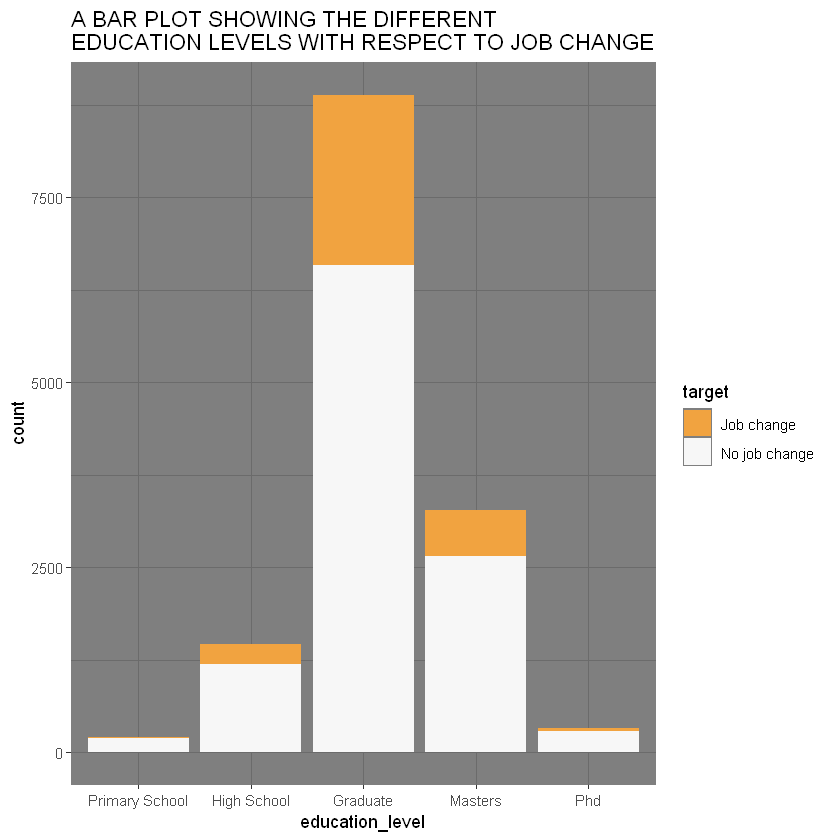

In [387]:
 ggplot(HR_data, aes(x=education_level, fill=target))+
            geom_bar(position = "stack")+
            scale_fill_brewer(palette = "PuOr")+
   labs(title = "A BAR PLOT SHOWING THE DIFFERENT \nEDUCATION LEVELS WITH RESPECT TO JOB CHANGE")+
            theme_dark()


 
 **Major discipline**
 
 
 Computing the ratios of each discipline in relation to the different levels of education:
 
 


In [388]:
mjd_count <- HR_data %>% 
   group_by(major_discipline) %>% 
   summarise(count=n())
 
 mjd_change <- HR_data %>% 
   filter(target=="Job change") %>% 
   group_by(major_discipline) %>%
   summarise(count=n())

 (mjd_change$count/mjd_count$count) * 100 


[1] 21.39303 25.00000 20.47532 25.00000 23.23944 23.09511

In [389]:
levels(mjd_change$major_discipline)



[1] "Arts"            "Business Degree" "Humanities"      "No Major"       
[5] "Other"           "STEM"

**Experience**


Number of people in each experience level:


In [390]:
 exper_count <- HR_data %>% 
   group_by(experience) %>% 
   summarise(count=n())
 
 exper_count<- arrange(exper_count, desc(count))
 


 Filtering out the extremes and observing their count:
 
 


In [391]:
 HR_data %>% 
   group_by(experience) %>% 
   filter(experience == "<1" | experience ==">20") %>% 
   summarise(count=n())


experience,count
<1,258
>20,2747


The people with higher experience(over 20 years) are many more than those with little experience(less than a year)


Looking at the trend between 1 year and 20 years experience


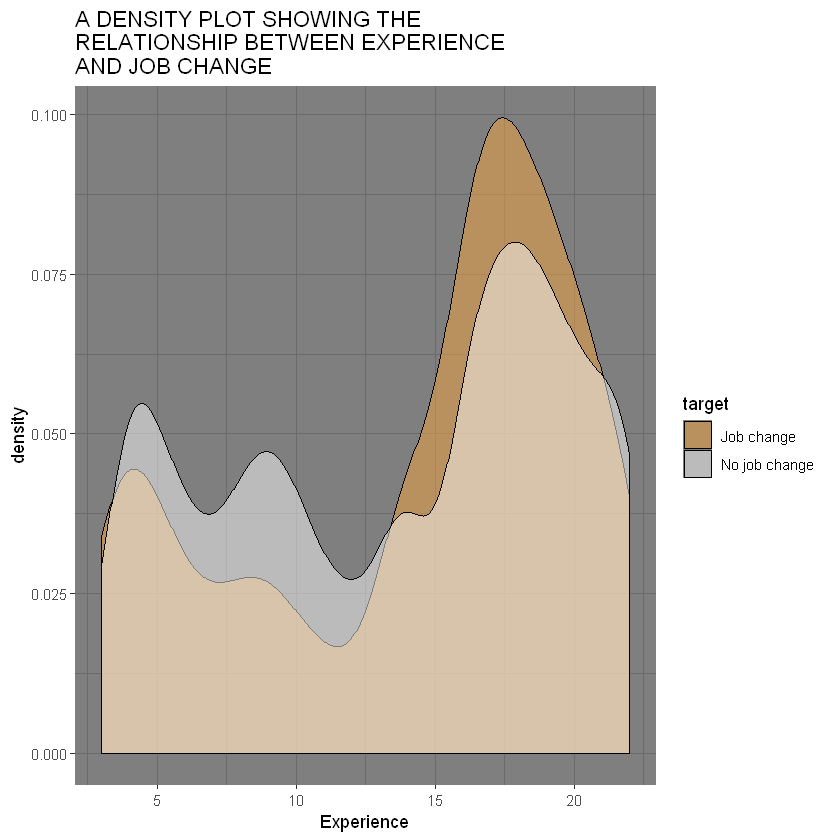

In [392]:
 exper <-  HR_data %>% 
   filter(experience != "<1" & experience !=">20") 
 

 ggplot(exper, aes(x=as.numeric(experience), fill=target))+
           geom_density(alpha=0.5)+
            labs(title = "A DENSITY PLOT SHOWING THE \nRELATIONSHIP BETWEEN EXPERIENCE \nAND JOB CHANGE", x="Experience")+
            scale_fill_brewer(palette = "PuOr")+
            theme_dark()


Those with **high experience** have a **higher likely hood of changing jobs**, as visualized above, while those with **lower experiences**(from 10 and below), have a **higher likely hood of not changing their current job**

 
 
 
 **Company size**
 
 The count of each company type:
 
 


In [393]:
 comp_count <- HR_data %>% 
   group_by(company_size) %>% 
   summarise(count=n()) 
 
 comp_count


company_size,count
<10,981
100-500,2033
1000-4999,1035
10000+,1564
50-99,2300
500-999,664
5000-9999,443
Unknown,5131


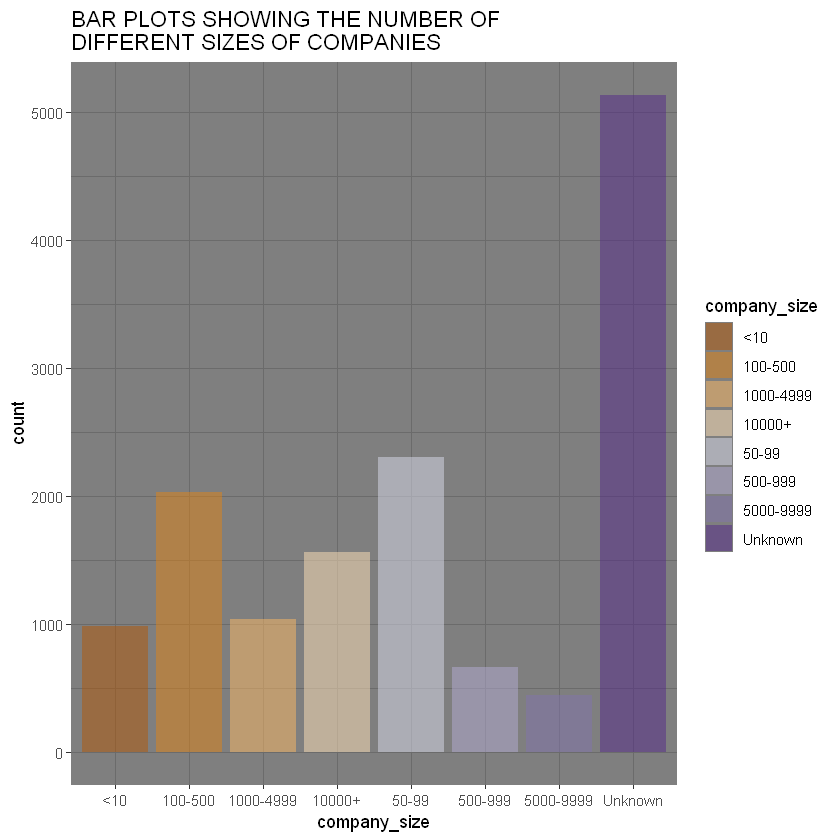

In [394]:
 ggplot(HR_data, aes(x=company_size, fill=company_size))+
            geom_bar(alpha=0.5)+
            scale_fill_brewer(palette = "PuOr")+
            labs(title="BAR PLOTS SHOWING THE NUMBER OF \nDIFFERENT SIZES OF COMPANIES")+
            theme_dark()
 


Looking at the job change:



In [395]:
 comp_change <- HR_data %>% 
   filter(target=="Job change") %>% 
   group_by(company_size) %>%
   summarise(count=n())
 
 comp_change$change <- ""
 comp_change$change  <- (comp_change$count/comp_count$count) * 100 

 comp_change


company_size,count,change
<10,144,14.67890
100-500,306,15.05165
1000-4999,147,14.20290
10000+,271,17.32737
50-99,361,15.69565
500-999,102,15.36145
5000-9999,71,16.02709
Unknown,1857,36.19178


Those from companies that have unidentified or unknown size(at 36.191%) have the heighest percentage of job change likely hood


A visual showing the same:


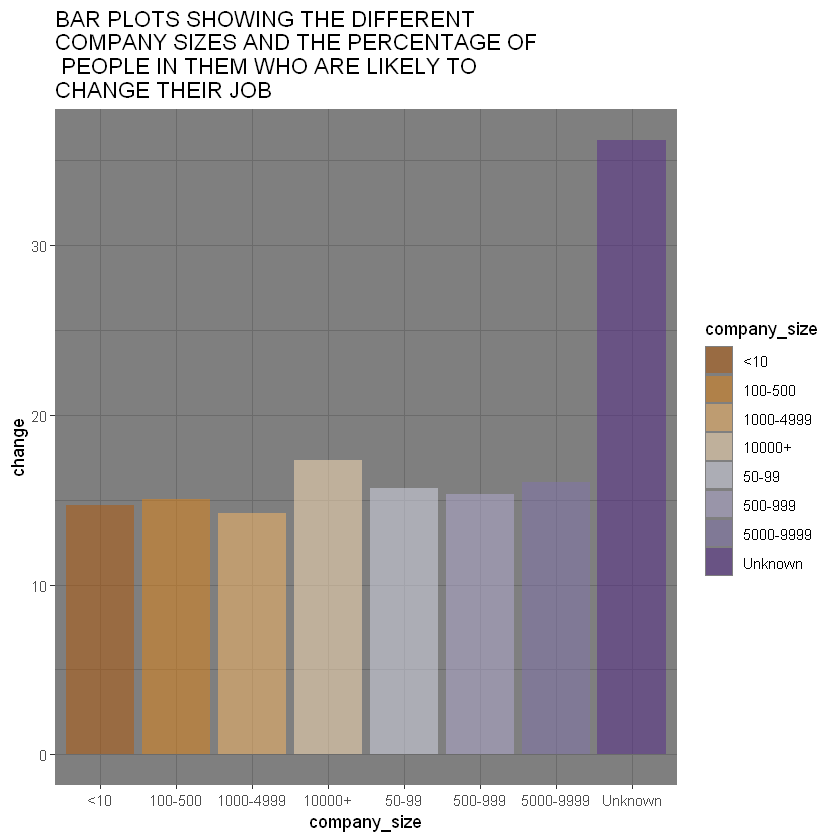

In [396]:
 ggplot(comp_change, aes(x=company_size, y = change, fill=company_size))+
             geom_col(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
             labs(title = "BAR PLOTS SHOWING THE DIFFERENT \nCOMPANY SIZES AND THE PERCENTAGE OF\n PEOPLE IN THEM WHO ARE LIKELY TO \nCHANGE THEIR JOB")+
             theme_dark()


 
 **Company Type** 
 
 Count:
 


In [397]:
 type_count <- HR_data %>% 
    group_by(company_type) %>% 
     summarise(count=n())


 type_count


company_type,count
Early Stage Startup,420
Funded Startup,833
NGO,396
Other,4226
Public Sector,702
Pvt Ltd,7574


The **most** populated company type is **Pvt Ltd** with **7574** people and the **least** populated is **NGO** with **396** people
 

Visual:
 


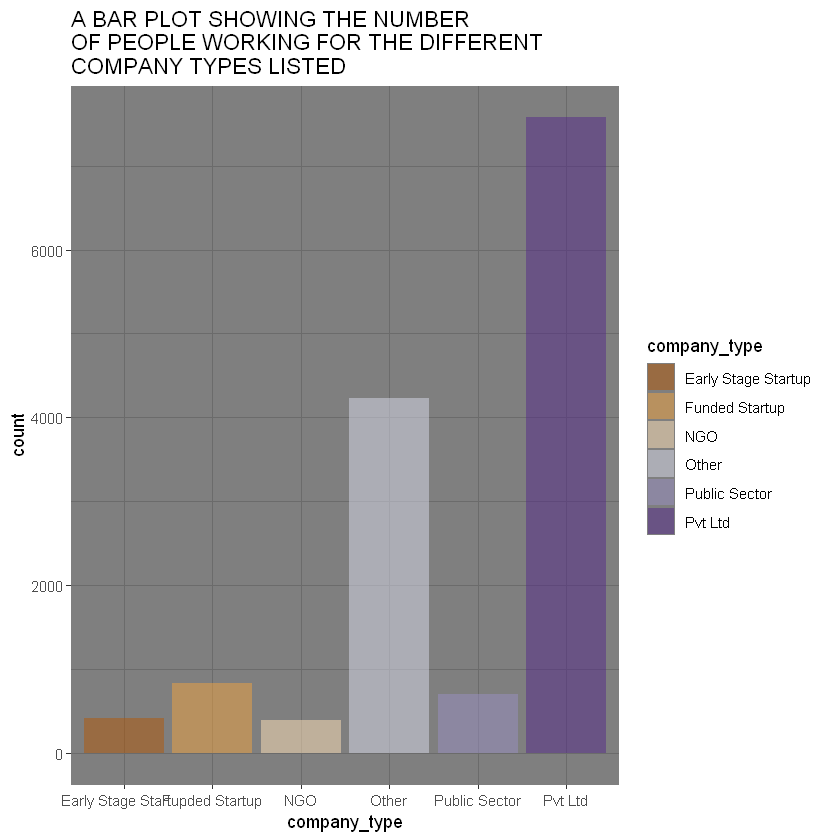

In [398]:
ggplot(HR_data, aes(x=company_type, fill=company_type))+
             geom_bar(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
             labs(title = "A BAR PLOT SHOWING THE NUMBER \nOF PEOPLE WORKING FOR THE DIFFERENT \nCOMPANY TYPES LISTED")+
             theme_dark()


Targeting the people who are likely to change jobs:

Looking at the rate of job change likelyhood: 


In [399]:
type_change <-   HR_data %>% 
    filter(target=="Job change") %>% 
    group_by(company_type) %>%
    summarise(count=n())
 
 type_change$change <- ""
 type_change$change  <- (type_change$count/type_count$count) * 100 

 type_change 


company_type,count,change
Early Stage Startup,88,20.95238
Funded Startup,113,13.56543
NGO,64,16.16162
Other,1619,38.31046
Public Sector,143,20.37037
Pvt Ltd,1232,16.26617


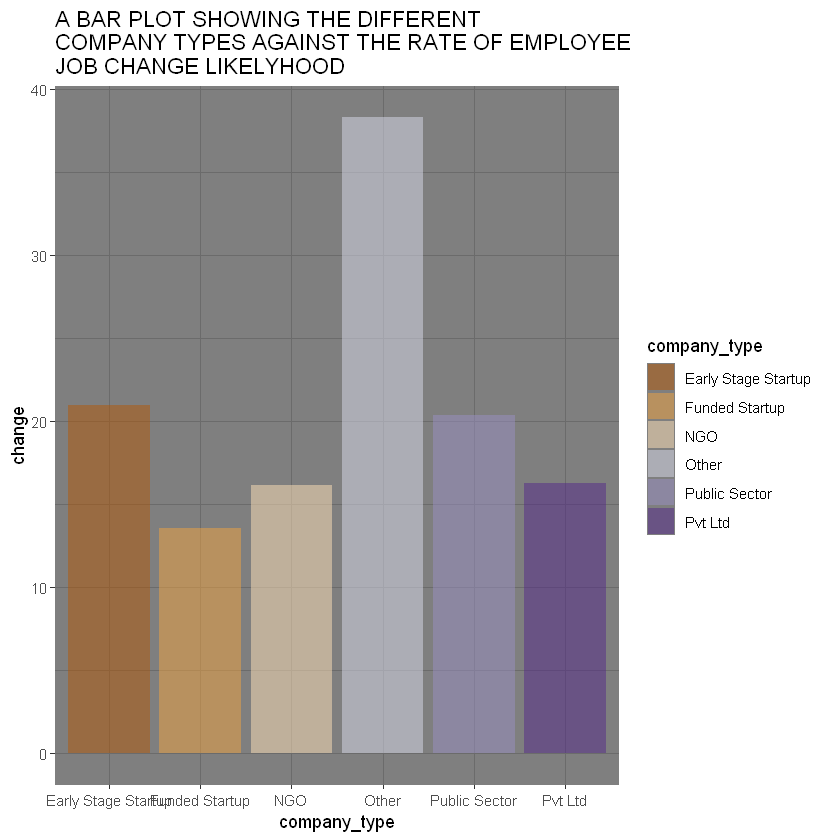

In [400]:
 ggplot(type_change, aes(x=company_type, y = change, fill=company_type))+
             geom_col(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
             labs(title = "A BAR PLOT SHOWING THE DIFFERENT \nCOMPANY TYPES AGAINST THE RATE OF EMPLOYEE \nJOB CHANGE LIKELYHOOD ")+
             theme_dark()


 
 
 **Last new job**
 
 Count: 
 
 


In [401]:
 last_job_count <- HR_data %>% 
    group_by(last_new_job) %>% 
     summarise(count=n())
 


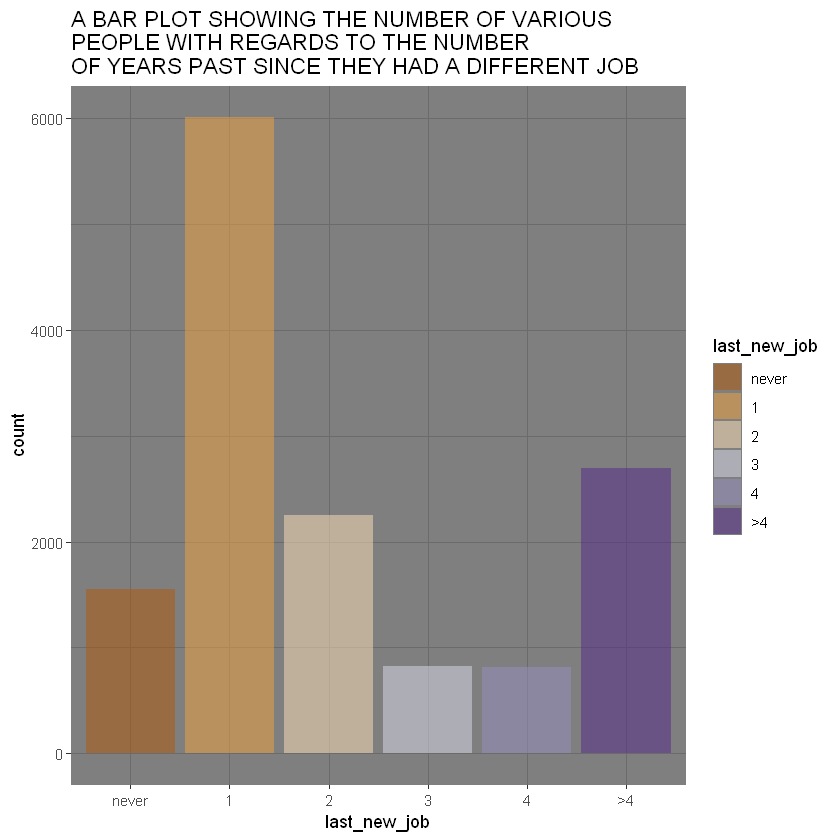

In [402]:
 ggplot(HR_data, aes(x=last_new_job, fill=last_new_job))+
             geom_bar(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
             labs(title = "A BAR PLOT SHOWING THE NUMBER OF VARIOUS \nPEOPLE WITH REGARDS TO THE NUMBER \nOF YEARS PAST SINCE THEY HAD A DIFFERENT JOB")+
             theme_dark()
 


Most people had changed jobs to work at a different place within one year




Targeting those likely to change jobs:

 


In [403]:
 last_job_change <- HR_data %>% 
    filter(target=="Job change") %>% 
    group_by(last_new_job) %>%
    summarise(count=n())

 last_job_change$change <- ""
 last_job_change$change  <- (last_job_change$count/last_job_count$count) * 100 

 last_job_change 


last_new_job,count,change
never,475,30.56628
1,1459,24.27621
2,516,22.88248
3,178,21.68088
4,175,21.41983
>4,456,16.92650


 
 The likeliest to change jobs**(at 30.566%)** are those who have **never** been at any previous new job - basically people are more likely to turnover at their first jobs.
 
 
 Visual:
 


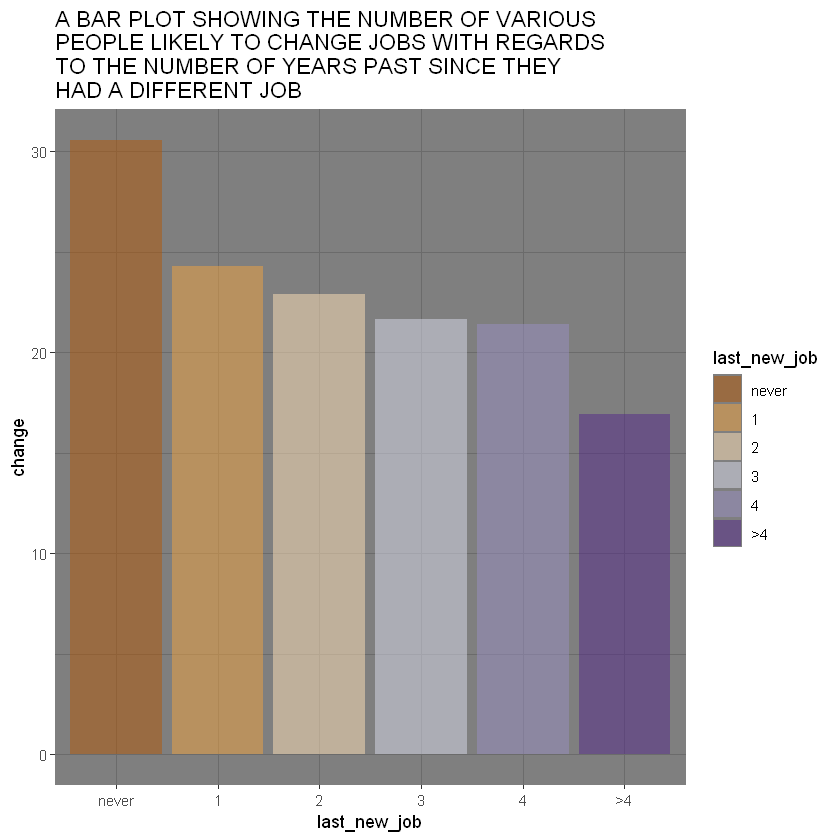

In [404]:
 ggplot(last_job_change, aes(x=last_new_job, y = change, fill=last_new_job))+
             geom_col(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
     labs(title = "A BAR PLOT SHOWING THE NUMBER OF VARIOUS \nPEOPLE LIKELY TO CHANGE JOBS WITH REGARDS \nTO THE NUMBER OF YEARS PAST SINCE THEY \nHAD A DIFFERENT JOB")+
             theme_dark()


As the number of years that a person spends in one job increases, the less likelier the person is to change jobs

 
 **Training hours**
 
 Descriptive measures:
 
 


In [405]:
 HR_data %>% 
     summarise(max=max(training_hours),median=median(training_hours),min=min(training_hours))


max,median,min
336,47,1


A maximum amount of hours of 336 and a minimum of 1 indicates a large deviation and volatility


Visual:


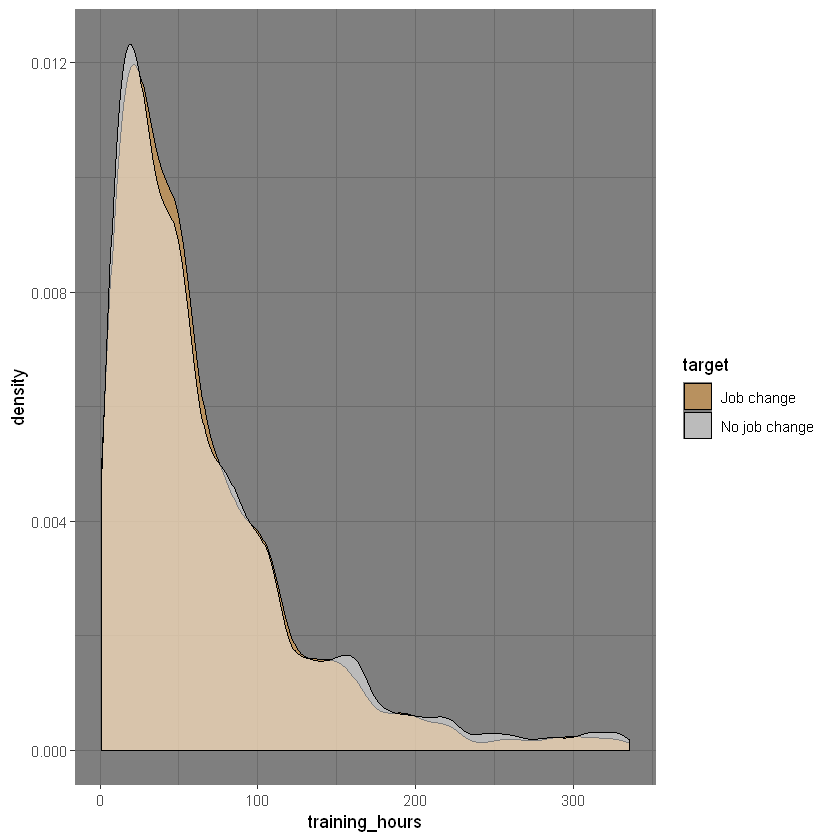

In [406]:
 ggplot(HR_data, aes(x=training_hours, fill=target))+
             geom_density(alpha=0.5)+
             scale_fill_brewer(palette = "PuOr")+
             theme_dark()


 
From the visual, it can be seen that the amounts of training hours are almost **similar** between both groups.
It is also apparent that the **people who spent less hours** on training are **greater** than those who spent more.




**Model Building**


 
 **Logistic regression**
 
The model uses numerical values to compute the linear probabilities, so we change the catergories to 1 and 0
1 - Job change  0 - No job change
 


In [407]:
 unique(HR_data$target)

 HR_data$target <- ifelse(HR_data$target == "Job change", 1, 0)
 
  unique(HR_data$target)


[1] "Job change"    "No job change"

[1] 1 0

Randomizing the data just in case patterns exist: 



In [408]:
random <- sample(1:(nrow(HR_data)))
HR_data <- HR_data[random,] 


Splitting into train and test:



In [409]:
split <- c(1:(nrow(HR_data) * 0.7))

hr_train <- HR_data[split,]
hr_test <- HR_data[-split,]


Dropping unused columns in the model to be fit:


Drop training hours


In [410]:
hr_train <- hr_train[,-11]



Fitting the model: 



In [411]:
hr_log_fit <- glm(target~., data=hr_train, family="binomial")
summary(hr_log_fit)



Call:
glm(formula = target ~ ., family = "binomial", data = hr_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0911  -0.6631  -0.4510  -0.3003   2.9494  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                                1.62716    0.47714   3.410 0.000649
city_development_index                    -5.65210    0.22529 -25.089  < 2e-16
genderMale                                -0.12768    0.09492  -1.345 0.178586
relevant_experienceNo relevent experience  0.27954    0.07348   3.804 0.000142
enrolled_universityno enrollment          -0.25746    0.07425  -3.468 0.000525
enrolled_universityPart time course       -0.44089    0.12300  -3.584 0.000338
education_levelHigh School                 0.75852    0.30176   2.514 0.011949
education_levelGraduate                    1.71042    0.29491   5.800 6.64e-09
education_levelMasters                     1.46393    0.30004   4.879 1.07e-06
education_

Using the model to predict the target variable in our test data:



In [412]:
hr_test$predict_log <- ""
hr_test$predict_log <- predict(hr_log_fit, hr_test, type = "response")
hr_test$predict_log <- ifelse(hr_test$predict_log >= 0.5, "Job change", "No job change")
hr_test$target <- ifelse(hr_test$target == 1, "Job change", "No job change")


Observing the predicted results on a confusion matrix:



In [413]:
table(hr_test$target)

xtabs(~target+predict_log, data = hr_test)



   Job change No job change 
          986          3260 

               predict_log
target          Job change No job change
  Job change           235           751
  No job change        159          3101

From the results above, the model is highly affected by the imbalanced target variable, and since it is a logistic model, its high bias tendancy leads to it mispredicting 724 cases where people were likely to seek a job change, but were classified as opposite.

The model is also highly specific and lowly sensitive due to this.


In [414]:
#specificity
(3127/(3127+152) * 100)

#sensitivity
(243/(243+724) * 100)


[1] 95.36444

[1] 25.12927

The above model would thus not be suitable for making accurate predictions on which employees are likely to change jobs, based on the data input provided.



**Decision Tree**

Changing the target categories from 1 and 0 to their respective placeholders for clarity when visualizing comparisons and the tree plot itself:


In [415]:
hr_train_tree <- hr_train

hr_train_tree$target <- ifelse(hr_train_tree$target == 1, "Job change", "No job change")


Fitting the model:



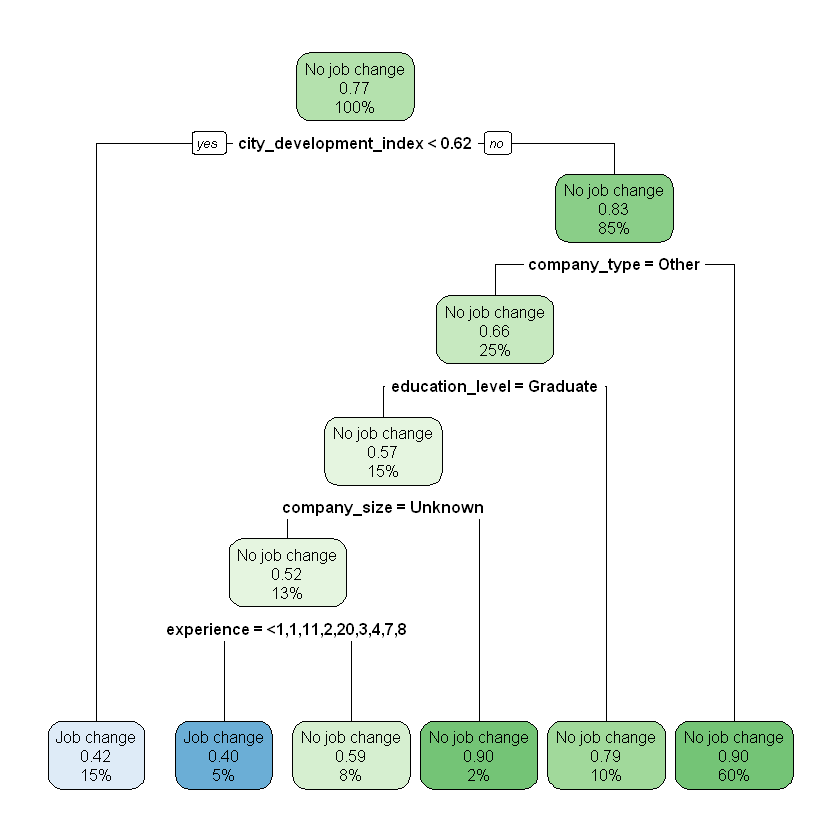

In [416]:
hr_tree_fit <- rpart(target~. , method = "class", data = hr_train_tree)
rpart.plot(hr_tree_fit)


Predictions:



In [417]:
hr_test$predict_tree <- ""
hr_test$predict_tree <- predict(hr_tree_fit, hr_test, type = "class")


A confusion matrix to visualise the predictions:



In [418]:
table(hr_test$target)

xtabs(~target+predict_tree, data = hr_test)



   Job change No job change 
          986          3260 

               predict_tree
target          Job change No job change
  Job change           498           488
  No job change        339          2921

In [419]:
# accuracy
((644+2809)/(984+3262)) * 100

# sensitivity
644/(644+340) * 100


[1] 81.3236

[1] 65.44715

The low bias nature of decision trees makes it able to obtain better predictions on the imbalanced target variable. Its true positive rate, as calculated in the sensitivity above is . Which is much higher than the logistic one at .

It is thus a better fit than the logistic model.


The decision tree model however, overfits easily due to their high variance nature - they are strongly influenced by the specifics of the training data - thus a large deviation in predictions when switching from one dataset to another.

Pruning the tree, or using parallel ensemble methods, eg: random forest can be used as a workaround against this issue



**Random Forest**


Decreases the variance of the model by adding more 'randomness'


In [420]:
hr_train_for <- hr_train



In [421]:
hr_train_for %>% 
   group_by(target) %>% 
    summarise(count=n())


target,count
0,7632
1,2273


    
    
The target variable is imbalanced since it exhibits an unequal distribution between its classes.
This becomes a problem when building machine learning models since algorithms assume that datasets have balanced classes.

This usually causes the performance of existing classifiers to get biased towards majority class.


*Oversampling*

- This technique replicates the observations from minority class to balance the data


In [422]:
#ROSE
balanced_over_for <- ovun.sample(target ~ ., data = hr_train_for, method = "over",N =15260)$data


The balanced dataset:



In [423]:
table(balanced_over_for$target)




   0    1 
7632 7628 

Randomizing - in case the new balanced dataset contains patterns



In [424]:
random <- sample(1:(nrow(balanced_over_for)))
balanced_over_for <- balanced_over_for[random,]


Changing the labels back to their placeholders for the random forest model building:



In [425]:
balanced_over_for$target <- ifelse(balanced_over_for$target == 1, "Job change", "No job change")


balanced_over_for$target <- factor(balanced_over_for$target)


*Tuning the model architecture*

Tuning the number of variables randomly sampled as candidates at each split - mtry


mtry = 3  OOB error = 10.77% 
Searching left ...
mtry = 2 	OOB error = 14.72% 
-0.36618 0.01 
Searching right ...
mtry = 4 	OOB error = 9.78% 
0.09245742 0.01 
mtry = 6 	OOB error = 9.13% 
0.06635389 0.01 
mtry = 9 	OOB error = 9.2% 
-0.007896626 0.01 


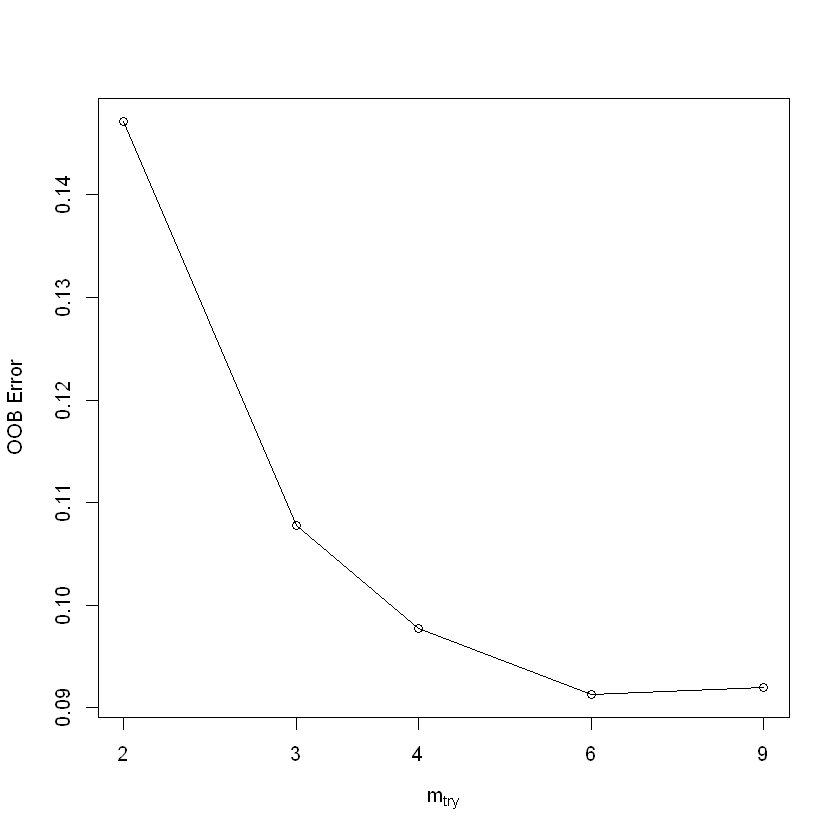

In [426]:
mtry <- tuneRF(balanced_over_for[-11],balanced_over_for$target, ntreeTry=800, stepFactor=1.5,improve=0.01, trace=TRUE, plot=TRUE)



The OOB error is decreasing with an increase in the randomly sampled values at each split
The lowest being at %.




The best value:


In [427]:
best.m <- mtry[mtry[, 2] == min(mtry[, 2]), 1]
print(mtry)
print(best.m)


      mtry   OOBError
2.OOB    2 0.14718218
3.OOB    3 0.10773263
4.OOB    4 0.09777195
6.OOB    6 0.09128440
9.OOB    9 0.09200524
[1] 6


We use mtry as 6 in the model building - yields the lowest error

Some other specifics that can be used to tune the model are specifying the number of trees, indicating the size and number of the different terminal nodes in the model or even limiting how deep the trees should be.

The model:


In [428]:
hr_for_fit <- randomForest(target~., data = balanced_over_for, ntree = 800, mtry = 6, importance = TRUE, replace = TRUE)



hr_for_fit



Call:
 randomForest(formula = target ~ ., data = balanced_over_for,      ntree = 800, mtry = 6, importance = TRUE, replace = TRUE) 
               Type of random forest: classification
                     Number of trees: 800
No. of variables tried at each split: 6

        OOB estimate of  error rate: 9.17%
Confusion matrix:
              Job change No job change class.error
Job change          7365           263  0.03447824
No job change       1136          6496  0.14884696

The model is now able to provide classifications for both variable classes in a more accurate fashion

The sensitivity before - %
The sensitivity after - %

The accuracy before - %
The accuracy after - %


A disadvantage of the sampling technique used is that since oversampling simply adds replicated observations in original data set, it ends up adding multiple observations of several types, thus leading to overfitting. 

We thus expect these values to reduce when performing the test with the original test dataset - which acts as our unseen data.


Testing the model on our test dataset:


In [429]:
hr_test$predict_for <- ""
hr_test$predict_for <- predict(hr_for_fit, hr_test, type = "class")

xtabs(~target+predict_for, data = hr_test)


               predict_for
target          Job change No job change
  Job change           559           427
  No job change        479          2781

Accuracy - 
Sensitivity - 

A better technique instead of replicating and adding the observations from the minority class, is overcoming the imbalances by generating artificial data through synthetic data generation.

It is more powerful, and overcomes the overfitting problem since it generates a random set of minority class observations to shift the classifier learning bias towards minority class by using bootstrapping and k-nearest neighbors.

Its implementation via SMOTE (synthetic minority oversampling technique) however, is only actionable on numerical data and not categorical.

For categorical features, the SMOTE-NC(synthetic minority oversampling technique - nominal continous) algorithm is used, but as of now there is no implementation of it in R - unless created using a custom function.
